
# EDA and Linear Regression — Taxes → Sell

> **Assignment-ready notebook**: Fill in the `DATA_PATH` below with the path to your CSV.  
> This notebook reads the data, performs EDA (with commentary), and fits two simple linear regression models:
> 1) `Sell` ~ `Taxes`
> 2) `Sell` ~ best other single numeric predictor (chosen by correlation with `Sell`, excluding `Taxes`).


In [12]:

# Setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import scatter_matrix

# IMPORTANT: set the path to your data file (CSV) here.
# Example: DATA_PATH = 'data/Housing.csv'
DATA_PATH = 'homes.csv'  # <-- replace with your file name/path

# Read data
df = pd.read_csv(DATA_PATH)

# Peek
display(df.head(10))
print("\nShape:", df.shape)


,Sell,List,Living,Rooms,Beds,Baths,Age,Acres,Taxes
0,142,160.0,28.0,10.0,5.0,3.0,60.0,0.28,3167.0
1,175,180.0,18.0,8.0,4.0,1.0,12.0,0.43,4033.0
2,129,132.0,13.0,6.0,3.0,1.0,41.0,0.33,1471.0
3,138,140.0,17.0,7.0,3.0,1.0,22.0,0.46,3204.0
4,232,240.0,25.0,8.0,4.0,3.0,5.0,2.05,3613.0
5,135,140.0,18.0,7.0,4.0,3.0,9.0,0.57,3028.0
6,150,160.0,20.0,8.0,4.0,3.0,18.0,4.00,3131.0
7,207,225.0,22.0,8.0,4.0,2.0,16.0,2.22,5158.0
8,271,285.0,30.0,10.0,5.0,2.0,30.0,0.53,5702.0
9,89,90.0,10.0,5.0,3.0,1.0,43.0,0.30,2054.0



Shape: (51, 9)



## Describe the dataset (code + commentary)

Below we show:
- Column names and data types (`.info()`)
- Summary statistics for numeric columns (`.describe()`)
- A quick check of missing values

These help confirm data quality, detect data-type issues (e.g., numeric stored as strings), and spot obvious anomalies before modeling.


In [39]:
# Structure and basic stats
df_info = df.info()
display(df.describe(numeric_only=True)) 

# Missing values overview
missing = df.isna().sum().sort_values(ascending=False)
display(missing.to_frame('n_missing'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sell    51 non-null     object 
 1   List    50 non-null     float64
 2   Living  50 non-null     float64
 3   Rooms   50 non-null     float64
 4   Beds    50 non-null     float64
 5   Baths   50 non-null     float64
 6   Age     50 non-null     float64
 7   Acres   50 non-null     float64
 8   Taxes   50 non-null     float64
dtypes: float64(8), object(1)
memory usage: 3.7+ KB


TypeError: NDFrame.describe() got an unexpected keyword argument 'numeric_only'


## EDA #1 — Distributions of key variables

Understanding the distribution of variables (especially the target `Sell` and key predictor `Taxes`) highlights skew, outliers, and scale issues that can affect linear regression assumptions (normality of residuals, homoscedasticity).


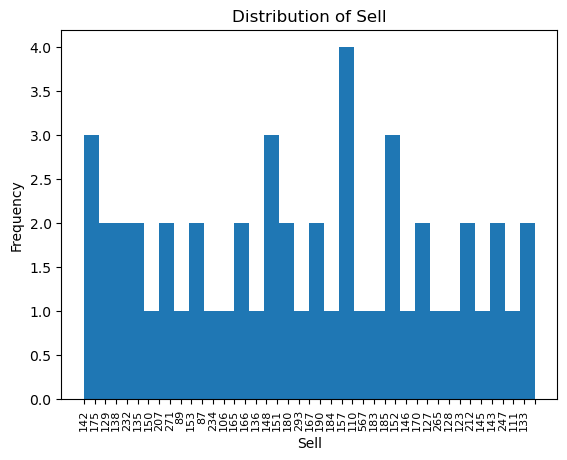

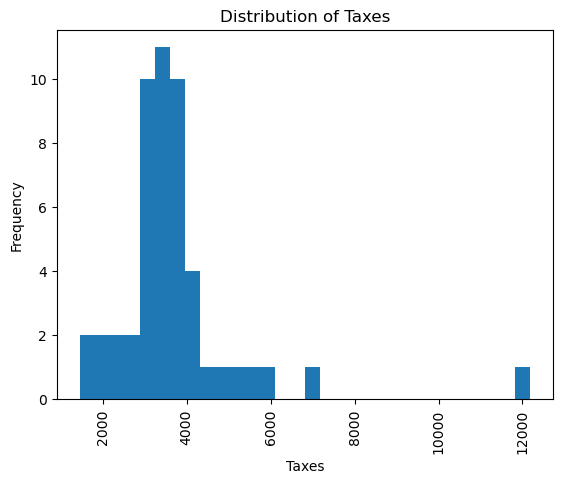

In [42]:
# Sell histogram
fig = plt.figure()
plt.hist(df['Sell'].dropna(), bins=30)
plt.title('Distribution of Sell')
plt.xlabel('Sell')
plt.ylabel('Frequency')
plt.xticks(rotation=90, fontsize=8)   # <-- rotate and reduce font size
plt.show()


# Taxes histogram
fig = plt.figure()
plt.hist(df['Taxes'].dropna(), bins=30)
plt.title('Distribution of Taxes')
plt.xlabel('Taxes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)   # <-- rotate x-axis labels
plt.show()



## EDA #2 — Relationship: `Sell` vs `Taxes`

A scatter plot shows the linearity/strength of association between `Taxes` and `Sell`. Linear regression assumes a linear relationship; clear patterns and limited heteroscedasticity are good signs.


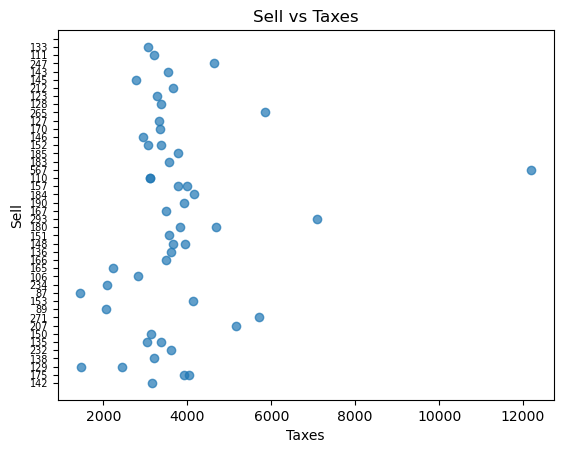

IndexError: index 1 is out of bounds for axis 0 with size 1

In [50]:

fig = plt.figure()
plt.scatter(df['Taxes'], df['Sell'], alpha=0.7)
plt.title('Sell vs Taxes')
plt.xlabel('Taxes')
plt.ylabel('Sell')
plt.yticks(fontsize=7) 
plt.show()

# Quick Pearson correlation
corr_tx = df[['Sell', 'Taxes']].corr(numeric_only=True).iloc[0,1]
print(f"Pearson correlation (Sell, Taxes): {corr_tx:.3f}")



## EDA #3 — Correlations and pairwise relationships

We examine the correlation of all numeric features with `Sell` and show a small scatter matrix for the top few. This helps identify other promising predictors and potential multicollinearity if we were to build larger models.


['Sell', 'List', 'Living', 'Rooms', 'Beds', 'Baths', 'Age', 'Acres', 'Taxes']


,corr_with_Sell
List,0.997433
Taxes,0.899339
Living,0.879381
Baths,0.640059
Rooms,0.560425
Beds,0.335113
Acres,0.168713
Age,-0.147343


<Figure size 640x480 with 0 Axes>

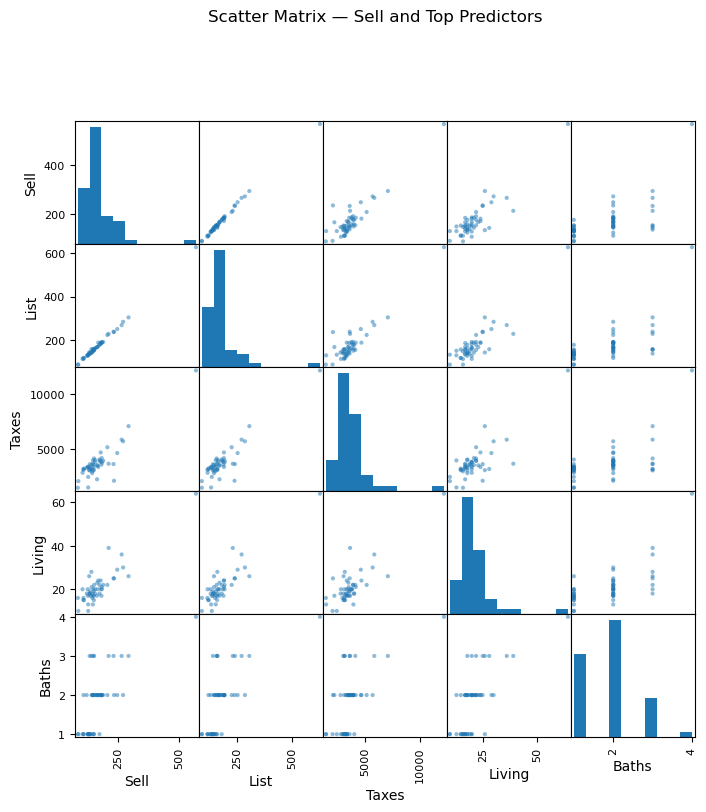

In [54]:
# 1) Inspect columns to find the target name
print(df.columns.tolist())

# 2) Map your real selling price column to 'Sell' (edit the right-hand side)
df = df.rename(columns={
    'selling_price': 'Sell',       # try your actual name here
    'sell_price': 'Sell',
    'SalePrice': 'Sell',
    'sale_price': 'Sell'
}, errors='ignore')

# 3) Ensure numeric types
df['Sell']  = pd.to_numeric(df['Sell'],  errors='coerce')
df['Taxes'] = pd.to_numeric(df['Taxes'], errors='coerce')

# 4) Re-run your correlation + scatter-matrix block safely
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'Sell' and c in df.columns]

if 'Sell' not in df.columns:
    raise KeyError("Could not find a 'Sell' column. Rename your target column to 'Sell' above.")

corr_with_sell = df[num_cols + ['Sell']].corr(numeric_only=True)['Sell'] \
                    .drop('Sell', errors='ignore').sort_values(ascending=False)
display(corr_with_sell.to_frame('corr_with_Sell'))

top_predictors = corr_with_sell.index[:4].tolist()
plot_cols = ['Sell'] + [c for c in top_predictors if c in df.columns]

if len(plot_cols) > 1:
    fig = plt.figure()
    scatter_matrix(df[plot_cols].dropna(), figsize=(8, 8))
    plt.suptitle('Scatter Matrix — Sell and Top Predictors', y=1.02)
    plt.show()
else:
    print("Not enough numeric columns to plot a scatter matrix.")



## Linear Regression — Model 1: `Sell` ~ `Taxes`

We fit an OLS model using `Taxes` as the independent variable and `Sell` as the dependent variable. We report the standard summary (coefficients, p-values, R², etc.) and check model diagnostics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Sell   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     203.1
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           7.22e-19
Time:                        11:58:42   Log-Likelihood:                -243.44
No. Observations:                  50   AIC:                             490.9
Df Residuals:                      48   BIC:                             494.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.8719     11.691      1.443      0.155      -6.635      40.378
Taxes          0.0414      0.003     14.250      0.000       0.036       0.047
==============================================================================
Omnibus:                       28.767   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.574
Skew:                           1.690   Prob(JB):                     1.16e-13
Kurtosis:                       7.144   Cond. No.                     1.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R^2: 0.809
RMSE: 31.493
Taxes coef: 0.0414, p-value: 7.22e-19


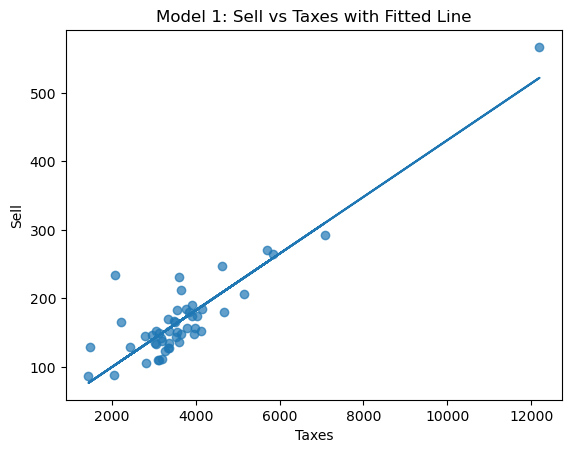

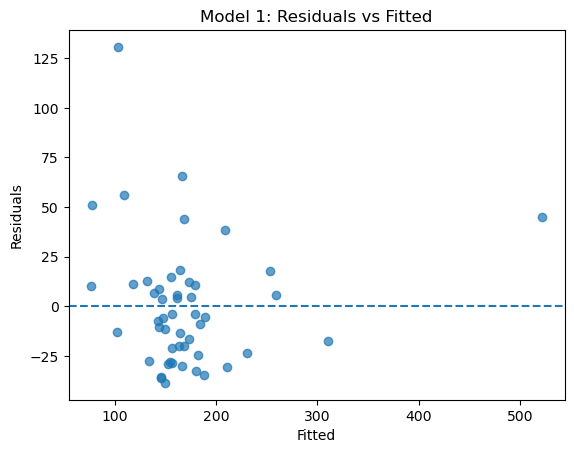

<Figure size 640x480 with 0 Axes>

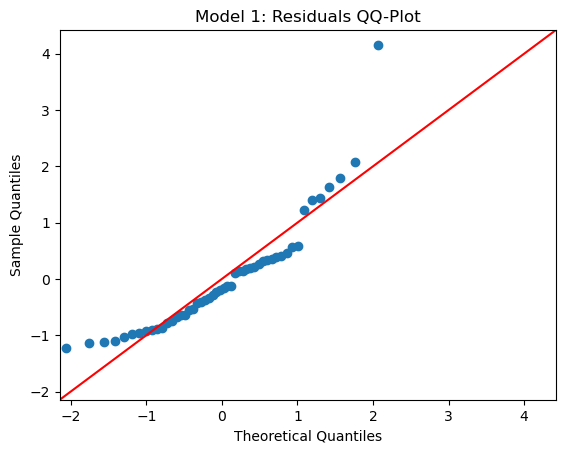

In [57]:

# Prepare data
y = df['Sell']
X1 = df[['Taxes']].copy()

# Drop rows with missing in either variable
valid_1 = y.notna() & X1['Taxes'].notna()
y1 = y[valid_1]
X1c = sm.add_constant(X1[valid_1])

# Fit model
model1 = sm.OLS(y1, X1c).fit()
display(model1.summary())

# Key stats
r2_1 = model1.rsquared
rmse_1 = np.sqrt(np.mean((y1 - model1.predict(X1c))**2))
pval_tax = model1.pvalues.get('Taxes', np.nan)
coef_tax = model1.params.get('Taxes', np.nan)

print(f"R^2: {r2_1:.3f}")
print(f"RMSE: {rmse_1:.3f}")
print(f"Taxes coef: {coef_tax:.4f}, p-value: {pval_tax:.3g}")

# Fitted line visualization
fig = plt.figure()
plt.scatter(X1c['Taxes'], y1, alpha=0.7)
plt.plot(X1c['Taxes'], model1.predict(X1c))
plt.title('Model 1: Sell vs Taxes with Fitted Line')
plt.xlabel('Taxes')
plt.ylabel('Sell')
plt.show()

# Diagnostics: residuals vs fitted, QQ plot
resid1 = model1.resid
fitted1 = model1.fittedvalues

fig = plt.figure()
plt.scatter(fitted1, resid1, alpha=0.7)
plt.axhline(0, linestyle='--')
plt.title('Model 1: Residuals vs Fitted')
plt.xlabel('Fitted')
plt.ylabel('Residuals')
plt.show()

fig = plt.figure()
sm.qqplot(resid1, line='45', fit=True)
plt.title('Model 1: Residuals QQ-Plot')
plt.show()



**Commentary:**  
- **Significance**: Inspect the p-value for `Taxes`. A small p-value (e.g., < 0.05) suggests `Taxes` is a statistically significant predictor of `Sell`.
- **Effect size**: The slope for `Taxes` shows the expected change in `Sell` per unit increase in `Taxes` (holding other factors out of this simple model).
- **Fit quality**: R² indicates the fraction of variance in `Sell` explained by `Taxes`. RMSE gives typical prediction error in the units of `Sell`.
- **Assumptions**: Residual plots help check linearity and homoscedasticity; QQ plot checks normality of residuals. Any strong patterns or heavy tails suggest model limitations.



## Linear Regression — Model 2: `Sell` ~ best single other predictor

We choose the **best** single numeric predictor by absolute correlation with `Sell` (excluding `Taxes`). This automates the choice in case column names differ across datasets.


In [ ]:

# Choose best other single predictor by |corr| with Sell, excluding Taxes
other_candidates = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ['Sell', 'Taxes']]
if other_candidates:
    best_other = (
        df[other_candidates + ['Sell']].corr(numeric_only=True)['Sell']
        .drop('Sell')
        .abs()
        .sort_values(ascending=False)
        .index[0]
    )
    print("Best single predictor (by |corr| with Sell, excl. Taxes):", best_other)

    y = df['Sell']
    X2 = df[[best_other]].copy()

    valid_2 = y.notna() & X2[best_other].notna()
    y2 = y[valid_2]
    X2c = sm.add_constant(X2[valid_2])

    model2 = sm.OLS(y2, X2c).fit()
    display(model2.summary())

    r2_2 = model2.rsquared
    rmse_2 = np.sqrt(np.mean((y2 - model2.predict(X2c))**2))
    print(f"R^2: {r2_2:.3f}")
    print(f"RMSE: {rmse_2:.3f}")

    # Plot
    fig = plt.figure()
    plt.scatter(X2c[best_other], y2, alpha=0.7)
    plt.plot(X2c[best_other], model2.predict(X2c))
    plt.title(f'Model 2: Sell vs {best_other} with Fitted Line')
    plt.xlabel(best_other)
    plt.ylabel('Sell')
    plt.show()

    # Diagnostics
    resid2 = model2.resid
    fitted2 = model2.fittedvalues

    fig = plt.figure()
    plt.scatter(fitted2, resid2, alpha=0.7)
    plt.axhline(0, linestyle='--')
    plt.title('Model 2: Residuals vs Fitted')
    plt.xlabel('Fitted')
    plt.ylabel('Residuals')
    plt.show()

    fig = plt.figure()
    sm.qqplot(resid2, line='45', fit=True)
    plt.title('Model 2: Residuals QQ-Plot')
    plt.show()
else:
    model2 = None
    print("No alternate numeric predictors available besides Taxes to build Model 2.")



## Which model is better? Limitations

We compare by **R²** (higher is better), **RMSE** (lower is better), and **AIC** (lower is better). Keep in mind these are **single-variable** models; real house prices are influenced by multiple features and interactions.


In [ ]:

def safe_aic(m):
    try:
        return m.aic
    except Exception:
        return np.nan

metrics = {
    'Model': ['Sell ~ Taxes', f"Sell ~ {best_other}" if 'best_other' in globals() and best_other else 'N/A'],
    'R2': [r2_1, r2_2 if 'r2_2' in globals() else np.nan],
    'RMSE': [rmse_1, rmse_2 if 'rmse_2' in globals() else np.nan],
    'AIC': [safe_aic(model1), safe_aic(model2) if 'model2' in globals() and model2 is not None else np.nan],
}
comp_df = pd.DataFrame(metrics)
display(comp_df)

better = None
if pd.notna(comp_df.loc[0,'R2']) and pd.notna(comp_df.loc[1,'R2']):
    better = comp_df.iloc[comp_df['R2'].idxmax()]['Model']
    print(f"By R^2, the better model here is: {better}")

print("\n**Limitations / Notes**")
print("- Single-predictor models ignore other drivers of price (e.g., size, location, rooms).")
print("- If residuals show patterns or heteroscedasticity, a linear model with one variable is likely misspecified.")
print("- Outliers can exert undue influence on slope estimates; consider robust regression or transformations if needed.")
print("- Correlation does not imply causation; domain context matters for interpretation.")



---

### How to submit
1. Replace `DATA_PATH` with your CSV path and **run all cells**.
2. Save the notebook (`File → Save`).
3. Push to your GitHub repository.
4. Submit the GitHub link per instructions.
